# Validation of SIS model (Numerical vs Analytical)

* This is in reference to Haris et al. (2018)

In [1]:
import numpy as np
from ler.lens_galaxy_population import OpticalDepth
import matplotlib.pyplot as plt
%matplotlib inline 

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

Setting multiprocessing start method to 'fork'


* optical_depth_SIS_hemanta is the numerical solution of the SIS model

* I will consider two cases with minimum velocity dispersion vd_min=0 and vd_min=50

* Haris et al. didn't assume any vd_min but Oguri et al. 2018 does (vd_min=50)

In [2]:
# vd_min = 0 km/s
od1 = OpticalDepth(
    npool=6,
    z_min=0., 
    z_max=10.,
    optical_depth_function="optical_depth_SIS_hemanta",
    sampler_priors=dict(
        velocity_dispersion="velocity_dispersion_gengamma",
        axis_ratio="axis_ratio_rayleigh",
    ),
    sampler_priors_params=dict(
        velocity_dispersion=dict(vd_min = 0., vd_max = 420., alpha = 2.32, beta = 2.67, phistar = 8.0e-3*cosmo.h**3, sigmastar = 161.0),
        axis_ratio=dict(q_min=0.2, q_max=1),
    ),
    cosmology=cosmo,
    directory="./interpolator_pickle",
    create_new_interpolator=True,
    )

z_to_Dc interpolator will be generated at ./interpolator_pickle/z_to_Dc/z_to_Dc_4.pickle
Dc_to_z interpolator will be generated at ./interpolator_pickle/Dc_to_z/Dc_to_z_4.pickle
angular_diameter_distance interpolator will be generated at ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_4.pickle
differential_comoving_volume interpolator will be generated at ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_4.pickle
velocity_dispersion_gengamma interpolator will be generated at ./interpolator_pickle/velocity_dispersion_gengamma/velocity_dispersion_gengamma_10.pickle
optical_depth_SIS_hemanta interpolator will be generated at ./interpolator_pickle/optical_depth_SIS_hemanta/optical_depth_SIS_hemanta_9.pickle


In [3]:
# vd_min = 50 km/s
od2 = OpticalDepth(
    npool=6,
    z_min=0., 
    z_max=10.,
    optical_depth_function="optical_depth_SIS_hemanta",
    sampler_priors=dict(
        velocity_dispersion="velocity_dispersion_gengamma",
        axis_ratio="axis_ratio_rayleigh",
    ),
    sampler_priors_params=dict(
        velocity_dispersion=dict(vd_min = 50., vd_max = 420., alpha = 2.32, beta = 2.67, phistar = 8.0e-3*cosmo.h**3, sigmastar = 161.0),
        axis_ratio=dict(q_min=0.2, q_max=1),
    ),
    cosmology=cosmo,
    directory="./interpolator_pickle",
    create_new_interpolator=True,
    )

z_to_Dc interpolator will be generated at ./interpolator_pickle/z_to_Dc/z_to_Dc_4.pickle
Dc_to_z interpolator will be generated at ./interpolator_pickle/Dc_to_z/Dc_to_z_4.pickle
angular_diameter_distance interpolator will be generated at ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_4.pickle
differential_comoving_volume interpolator will be generated at ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_4.pickle
velocity_dispersion_gengamma interpolator will be generated at ./interpolator_pickle/velocity_dispersion_gengamma/velocity_dispersion_gengamma_8.pickle
optical_depth_SIS_hemanta interpolator will be generated at ./interpolator_pickle/optical_depth_SIS_hemanta/optical_depth_SIS_hemanta_7.pickle


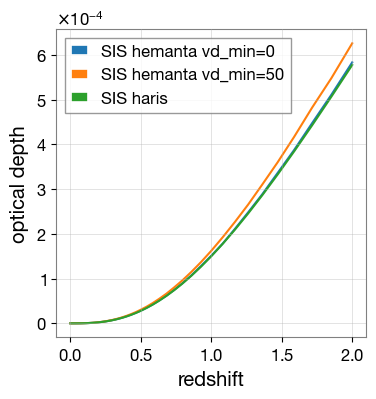

In [4]:
zs = np.geomspace(0.001, 2, 100)
tau_sis1 = od1.strong_lensing_optical_depth(zs)
tau_sis2 = od2.strong_lensing_optical_depth(zs)
tau_sis_haris = od1.optical_depth_SIS_haris(zs)

# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis1, label='SIS hemanta vd_min=0')
plt.plot(zs, tau_sis2, label='SIS hemanta vd_min=50')
plt.plot(zs, tau_sis_haris, label='SIS haris')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

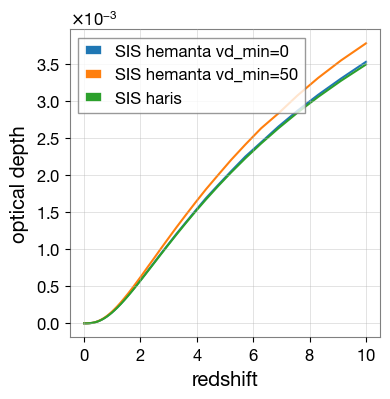

In [11]:
zs = np.geomspace(0.001, 10, 100)
tau_sis1 = od1.strong_lensing_optical_depth(zs)
tau_sis2 = od2.strong_lensing_optical_depth(zs)
tau_sis_haris = od1.optical_depth_SIS_haris(zs)

# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis1, label='SIS hemanta vd_min=0')
plt.plot(zs, tau_sis2, label='SIS hemanta vd_min=50')
plt.plot(zs, tau_sis_haris, label='SIS haris')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

* close enough

* Without vd_min constraint, the numerical solution overlaps the analytical solution

* Below $\sigma<2$ velocity dispersion minimum with vd_min=50, is close but not exact.

* Let's try to integrate it

In [15]:
# integration 
from scipy.integrate import quad

z_max = 10
def integrand1(z):
    return od1.strong_lensing_optical_depth(np.array([z]))[0]

tau1, _ = quad(integrand1, 0, z_max)

def integrand2(z):
    return od2.strong_lensing_optical_depth(np.array([z]))[0]

tau2, _ = quad(integrand2, 0, z_max)

def integrand3(z):
    return od1.optical_depth_SIS_haris(np.array([z]))[0]

tau3, _ = quad(integrand3, 0, z_max)

print(tau1, tau2, tau3)

0.018368515181022536 0.019730039480023977 0.018224115533469337


In [16]:
print(f"strong lensing amount difference between numerical and analytical method: {abs(tau2-tau3)/tau3 * 100}%")

strong lensing amount difference between numerical and analytical method: 8.263358206816394%


* 8% difference in the numerical (vd_min=50) and analytical solution

* Reason: More small velocity dispersion, having smaller cross section, included in the analytical solution.

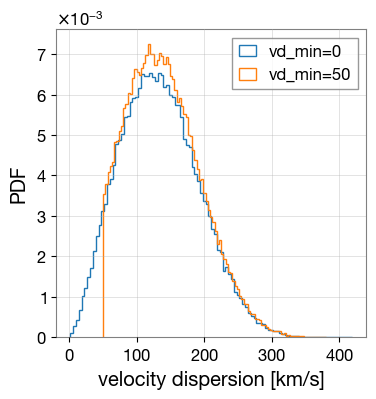

In [7]:
# velocity dispersion distribution PDF
vd1 = od1.sample_velocity_dispersion(100000)
vd2 = od2.sample_velocity_dispersion(100000)

plt.figure(figsize=(4,4))
plt.hist(vd1, bins=100, histtype='step', label='vd_min=0',density=True)
plt.hist(vd2, bins=100, histtype='step', label='vd_min=50',density=True)
plt.xlabel('velocity dispersion [km/s]')
plt.ylabel('PDF')
plt.legend()
plt.grid(alpha=0.5)
plt.show()